In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Time series generation functions

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """Helper function to plot our time series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    """Define the trend through slope and time"""
    return slope * time

def seasonal_pattern(season_time):
    """Arbitrary definition of a seasonality pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats a pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds white noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
from dataclasses import dataclass

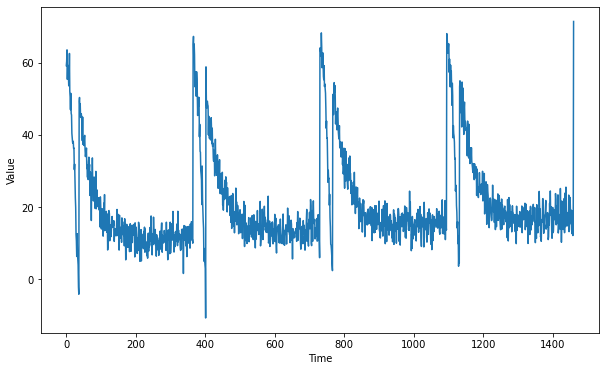

In [4]:

def generate_time_series():
    # Temporal dimension: 4 years of data
    time = np.arange(4 * 365 + 1, dtype="float32")

    # The initial series is nothing more than a straight line which we will then modify with the other functions
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Add seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Add noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Let's save the parameters of our time series in the dataclass
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100 # on day 1100 the training period will end. The rest will belong to the validation set
    WINDOW_SIZE = 20 # how many data points will we take into account to make our prediction
    BATCH_SIZE = 32 # how many items will we supply per batch
    SHUFFLE_BUFFER_SIZE = 1000 # we need this parameter to define the Tensorflow sample buffer
    
    
# plot the series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [5]:
#TIME, SERIES = generate_time_series()
#plt.plot(SERIES[40:120])

# Preprocessing of the time series for deep learning

In [6]:

def train_val_split(time, series, time_step=G.SPLIT_TIME):
	"""Divide the time series into training and validation set"""
	time_train = time[:time_step]
	series_train = series[:time_step]
	time_valid = time[time_step:]
	series_valid = series[time_step:]

	return time_train, series_train, time_valid, series_valid

def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
	"""
	We create time windows to create X and y features.
	For example, if we choose a window of 30, we will create a dataset formed by 30 points as X
	"""
	dataset = tf.data.Dataset.from_tensor_slices(series)
	dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
	dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
	dataset = dataset.shuffle(shuffle_buffer)
	dataset = dataset.map(lambda window: (window[:-1], window[-1]))
	dataset = dataset.batch(batch_size).prefetch(1)
	return dataset

In [7]:
# we divide into training and validation set
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [8]:
# let's create the dataset with time windows
dataset = windowed_dataset(series_train)


# Neural network architecture

In [9]:

def create_uncompiled_model():
  # define a sequential model
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                    input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),
  ]) 

  return model

# The EarlyStopping callback

In [10]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('mae') < 0.03):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

# Model training

In [11]:
def create_model():
    tf.random.set_seed(51)
  
    model = create_uncompiled_model()
  
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mae"])  
    return model
  
model = create_model()

# we train for 20 epochs with and assign the callback
history = model.fit(dataset, epochs=100, callbacks=[early_stopping])

Epoch 1/100
34/34 [==============================] - 20s 56ms/step - loss: 8.8506 - mae: 9.3294
Epoch 2/100
34/34 [==============================] - 2s 44ms/step - loss: 7.1515 - mae: 7.6289
Epoch 3/100
34/34 [==============================] - 2s 44ms/step - loss: 7.1430 - mae: 7.6135
Epoch 4/100
34/34 [==============================] - 2s 44ms/step - loss: 7.1424 - mae: 7.6136
Epoch 5/100
34/34 [==============================] - 2s 52ms/step - loss: 7.1437 - mae: 7.6146
Epoch 6/100
34/34 [==============================] - 2s 50ms/step - loss: 7.1378 - mae: 7.6096
Epoch 7/100
34/34 [==============================] - 2s 45ms/step - loss: 7.1478 - mae: 7.6209
Epoch 8/100
34/34 [==============================] - 2s 54ms/step - loss: 7.1485 - mae: 7.6199
Epoch 9/100
34/34 [==============================] - 2s 45ms/step - loss: 7.6166 - mae: 8.0908
Epoch 10/100
34/34 [==============================] - 2s 45ms/step - loss: 7.1429 - mae: 7.6128
Epoch 11/100
34/34 [============================

# Save Model Weights

In [ ]:
model.save("nn.h5")

# Evaluation of the model

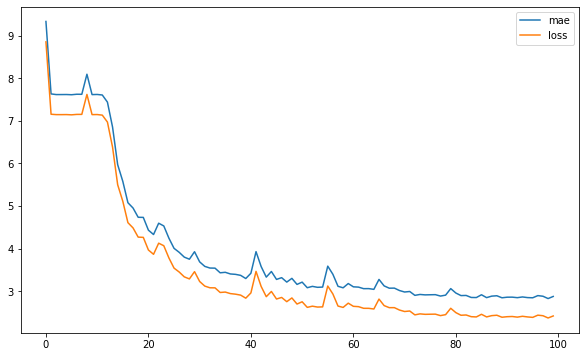

In [12]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

# Metrics Compution

In [13]:

def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

def model_forecast(model, series, window_size):
  """This function converts the input series into a dataset with time windows for forecasting"""
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

# Prediction on the whole series

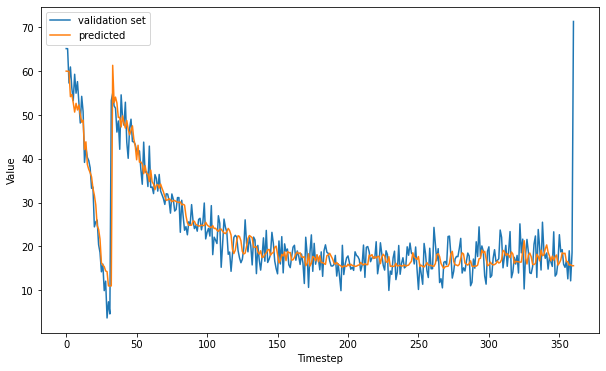

In [14]:

# Prediction on the whole series
all_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Validation portion
val_forecast = all_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(series_valid, label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

In [16]:
val_forecast = all_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]


In [17]:

mse, mae = compute_metrics(series_valid, val_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f}")

mse: 26.57, mae: 3.15


# Predicting a new point in the future

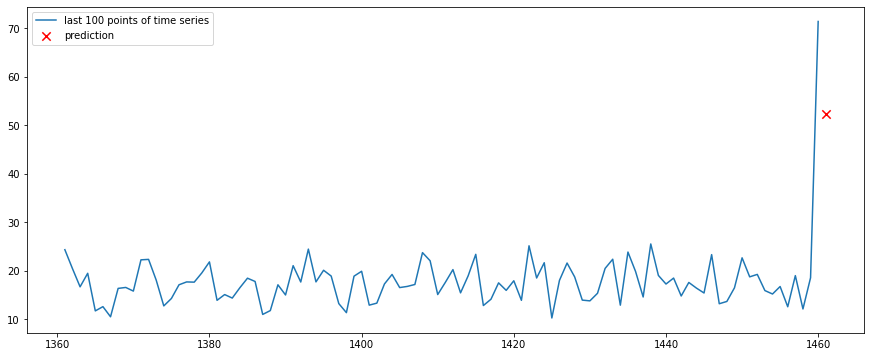

In [19]:
new_forecast = []

new_forecast_series = G.SERIES[-G.WINDOW_SIZE:] 

pred = model.predict(new_forecast_series[np.newaxis])

plt.figure(figsize=(15, 6))
plt.plot(G.TIME[-100:], G.SERIES[-100:], label="last 100 points of time series")
plt.scatter(max(G.TIME)+1, pred, color="red", marker="x", s=70, label="prediction")
plt.legend()
plt.show()

# INFERENCE


In [ ]:
#load the model
model_loaded=tf.keras.models.load_model("nn.h5")

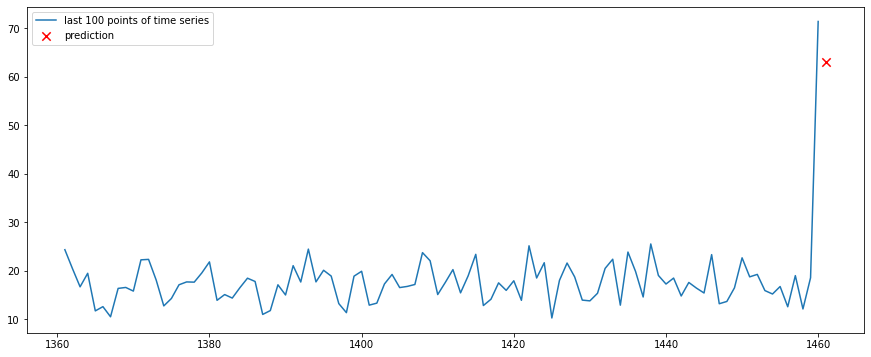

In [ ]:

new_forecast_series = G.SERIES[-G.WINDOW_SIZE:]
new_forecast_series = np.expand_dims(new_forecast_series, axis=0)


pred = model_loaded.predict(new_forecast_series)

plt.figure(figsize=(15, 6))
plt.plot(G.TIME[-100:], G.SERIES[-100:], label="last 100 points of time series")
plt.scatter(max(G.TIME)+1, pred, color="red", marker="x", s=70, label="prediction")
plt.legend()
plt.show()